In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

from torch.utils.data import Dataset

In [0]:
from itertools import combinations

In [0]:
from tqdm import tqdm

In [0]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

# ***Pedagogical Example for MVAE***

**Partners**: Jonathan Chu, Rajath Salegame, Michael Zhang (listed alphabetically)

**Paper citation**: Wu, Mike, and Noah Goodman. "Multimodal generative models for scalable weakly-supervised learning." Advances in Neural Information Processing Systems. 2018.

Commentary on the multimodal VAE and our pedagogical simulation setup. As opposed to Wu et al, which evaluates on a multimodal dataset composed of images (MNIST, CelebA) and their respective labels as modalities, we stick to numerical distributions, which are computationally easier but more importantly can be carefully designed to either fit or break the MVAE's modeling assumptions.

## ***Dataset***
To test the efficacy of our multimodal VAE, we would like to see how well the VAE does in regard to estimating an arbitary numerical data distribution. Simulating this data, we can establish three base cases:
1. Data fits the assumption exactly: have a hierarchical model where conditioning on a latent $z$, the modalities $x_i$ are independent (but unconditionally dependent)  
2. Data is unconditionally independent  
3. Data is conditionally dependent

We will describe the above with a bit more detail below, and even more in our actual examples section further below. For simplicity, we stick to Gaussians with linear transforms.

***1. Conditionally Independent***

Here we assume an underlying $Z \sim \mathcal{N}(\mu, \sigma^2)$, and then each of our modalities is given by

$$
X_i \sim a_iZ + b_i + \mathcal{N}(\mu_i, \sigma_i^2)
$$

In the simplest case, we could have $a_i$ and $b_i$ be the integers $n \in [1, N]$ and $\mu_i, \sigma_i^2 = (0, 1) \;\forall\; i$

***2. Dependent***  
Now we assume that our modalities are dependent on each other, e.g.

$$
X_i \sim a_i Z + b_i
$$

with $a_i$ and $b_i$ as described above.

***3. Unconditionally Independent***

In this case we just assume that our modalities come from independent Normals, e.g. 

$$
X_i \sim b_i + \mathcal{N}(\mu_i, \sigma_i^2)
$$





In [0]:
class MultimodalDataset(Dataset):
    """
    Multimodal normal dataset
    :latent_mu: latent mean
    :latent_sigma: latent standard deviation
    :alphas: list of modality coefficients
    :means: list of means, e.g. M = [m_1, ..., m_N]
    :sigmas: list of sigmas, e.g. S = [s_1, ..., s_N]
    :size: number of datapoints to sample per initialization
    :seed: random seed
    :independence: one of ('conditional' | 'unconditional' | 'dependent')
    """
    def __init__(self, latent_mu, latent_sigma, alphas, betas, means, 
                 sigmas, size, seed=42, independence='conditional'):
        self.latent_mu = latent_mu
        self.latent_sigma = latent_sigma
        self.alphas = alphas
        self.betas = betas
        self.means = means
        self.sigmas = sigmas
        self.size = size
        self.seed = seed
        self.independence = independence

        assert len(alphas) == len(means)
        assert len(betas) == len(means)
        assert len(means) == len(sigmas)

        self.n_modalities = len(alphas)
        self.modalities = [[] for i in range(self.n_modalities)]
        self.samples = []

        np.random.seed(self.seed)
        self.load_data()

    def __getitem__(self, ix):
        return torch.tensor([modality[ix] for modality in self.modalities], 
                            dtype=torch.float)

    def __len__(self):
        return self.size

    def sample(self, mean, sigma, size=1):
        return np.random.normal(mean, sigma, size)

    def load_data(self):
        if independence != 'unconditional':
            latent_data = self.sample(self.latent_mu, self.latent_sigma, self.size)
            for ix, modality in enumerate(self.modalities):
                if independence == 'conditional':
                    for i in range(self.size):
                        modality.append(self.alphas[ix] * latent_data[i] + 
                                        self.betas[ix] +
                                        self.sample(means[ix], sigmas[ix], size=1)[0])
                elif independence == 'dependent':
                    modality.extend(self.alphas[ix] * latent_data + self.betas[ix])
        else:
            for ix, modality in enumerate(self.modalities):
                modality.extend(self.betas[ix] + 
                                self.sample(means[ix], sigmas[ix], size=self.size))
            
        

In [0]:
def load_multimodal_dataset(latent_mu, latent_sigma, 
                            alphas, betas, means, sigmas, size, 
                            seed=42, independence='conditional',
                            batch_size=256, shuffle=True):
  
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    dataset = MultimodalDataset(latent_mu, latent_sigma, alphas, betas, 
                                means, sigmas, size, seed, independence)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                             shuffle=shuffle)
    return dataloader

## ***MVAE Implementation***

#### ***Product of Experts***

Recall that because of the assumption that our observed modalities are conditionally independent, we can estimate the conditional joint distribution with

$$p(z | x_1, \ldots, x_N) \propto p(z) \prod_{i=1}^N \tilde{q}(z \mid x_i)$$

where $p(z) \sim \mathcal{N}(0, 1)$ for the canonical standard normal prior. Denote this with the following code:

In [0]:
def prior_expert(dim):
    """Prior expert in PoE model. Use N(0, 1)"""
    return torch.zeros(dim).cuda(), torch.log(torch.ones(dim)).cuda()

As noted in [(Cao and Fleet 2015)](https://arxiv.org/pdf/1410.7827.pdf), assuming Gaussian experts, the product distribution should still be Gaussian. Given data and labels $x$ and $y$, we have
$$
P(y \mid x) = \frac{1}{N}\prod_{i}p_i(y \mid x), \text{ where }p_i(y \mid x) = \mathcal{N}(m_i(x), \Sigma_i(x))
$$

in the supervised setting for $N$ experts. The product is then
$$
P(y \mid x) \sim \mathcal{N}(m(x), \Sigma(x))
$$
where
$$
m(x) = \Big(\sum_{i}^N m_i(x) T_i(x)\Big) \cdot \Big(\sum_i T_i(x)\Big)^{-1}
\text{ and }
\Sigma(x) = \Big(\sum_{i}^N T_i(x)\Big)^{-1}
$$
where $T_i(x) = \Sigma_i^{-1}(x)$ is the precision of the $i$-th expert at data point $x$. We can then code this up as

In [0]:
def product_of_experts(mu_n, log_var_n, a_n=None, eps_n=1e-8):
    """
    Product of Experts function. Also including alpha_n for generalized PoE (gPoE)
    :mu_n: m_i(x), should be N X D for N experts, D dimensions
    :log_var_n: sigma_i(x), (N X D)
    :eps_n: include epsilon to avoid dividing by zero
    :a_n: reliablity vector for each expert, (N x 1)
    """
    T = torch.tensor(1. / (torch.exp(log_var_n) + eps_n), dtype=torch.float).cuda()
    if a_n is not None:
        mu = torch.sum(mu_n * a_n * T, dim=0) / torch.sum(a_n * T, dim=0)
        var = 1. / torch.sum(a_n * T, dim=0)
    else:
        mu = torch.sum(mu_n * T, dim=0) / torch.sum(T, dim=0)
        var = 1. / torch.sum(T, dim=0)

    # print('PoE SHAPE: {}'.format(mu.shape))  # debug

    return mu.cuda(), torch.log(var).cuda()
    

#### ***MVAE***

We'll define a single class for the MVAE that takes care of all $N$ modalities we might come across. Accordingly, we can modularize by creating classes for the numerical encoder and decoder, where we'll have an encoder $\tilde{q}_i(z \mid x)$ for each modality indexed by $i \in \{1, \ldots, N\}$:

In [0]:
class ModalEncoder(nn.Module):
    """
    Encoder, i.e. q_i(z | x)
    :latent_dim: Number of dimensions to model z (in our case = 1 if Z ~ N(0, 1))
    """
    def __init__(self, latent_dim=1):
        super(ModalEncoder, self).__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc_mu = nn.Linear(5, latent_dim)
        self.fc_sd = nn.Linear(5, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # sigmoid in the paper
        return self.fc_mu(x), self.fc_sd(x)

class ModalDecoder(nn.Module):
    """
    Decoder, i.e. p_i(x | z)
    :latent_dim: same as for encoder
    """
    def __init__(self, latent_dim=1):
        super(ModalDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, z):
        return self.fc2(F.relu(self.fc1(z)))
    
   

Now to actually code up the MVAE, we have:

In [0]:
class MVAE(nn.Module):
    """
    Multimodal VAE
    :n_modalities: number of modalities to model
    :latent_dim: number of dimensions for z (default = 1)
    """
    def __init__(self, n_modalities, latent_dim=1):
        super(MVAE, self).__init__()
        encoders = [ModalEncoder(latent_dim=latent_dim) for ix in 
                    range(n_modalities)]
        decoders = [ModalDecoder(latent_dim=latent_dim) for ix in 
                    range(n_modalities)]
        self.encoder_n = nn.ModuleList(encoders)
        self.decoder_n = nn.ModuleList(decoders)

        self.n_modalities = n_modalities
        self.latent_dim = latent_dim

    def encode(self, X):
        """
        For each modality, infer mean and variance
        :X: list of data modalities
        """
        # Get the prior
        mu, log_var = prior_expert((1, batch_size, self.latent_dim))
        # mu, log_var = prior_expert((batch_size, self.latent_dim))
        # Calculate q(z_i | x_i) for each x_i
        for i in range(self.n_modalities):
            if type(X) == list:
                if X[i] is not None:
                    x_mu, x_log_var = self.encoder_n[i](X[i].unsqueeze(1))  # 
                    mu = torch.cat((mu, x_mu.unsqueeze(0)), dim=0)
                    log_var = torch.cat((log_var, x_log_var.unsqueeze(0)), dim=0)
            else:
                if X[:, i] is not None:
                    x_mu, x_log_var = self.encoder_n[i](X[:, i].unsqueeze(1))  # 
                    mu = torch.cat((mu, x_mu.unsqueeze(0)), dim=0)
                    log_var = torch.cat((log_var, x_log_var.unsqueeze(0)), dim=0)
            
        # Product of Experts
        # print('mu shape: {}'.format(mu.shape))  # debug
        return product_of_experts(mu, log_var)

    def decode(self, z):
        """
        Given the inferred mean and variance, generate reconstructed x
        """
        x_hat_n = []
        for i in range(self.n_modalities):
            x_hat = self.decoder_n[i](z)
            x_hat_n.append(x_hat.squeeze(1))
        return torch.stack(x_hat_n)

    def reparameterize(self, mu, log_var):
        """Everyone's favorite trick"""
        sd = torch.exp(torch.mul(log_var, 0.5))
        # Generate standard normal and then add, e.g. X = sd_X * N(0, 1) + mu_X
        standard_norm = torch.tensor(np.random.normal(0., 1., sd.size()), 
                                     dtype=torch.float).cuda()
        return torch.add(torch.mul(standard_norm, sd), mu)
    
    def forward(self, X):
        mu, log_var = self.encode(X)
        z = self.reparameterize(mu, log_var)
        x_hat_n = self.decode(z)
        # print('SHAPE OF RECONSTRUCTION: {}'.format(x_hat_n.shape)) # debug
        return x_hat_n, mu, log_var


# ***Training + Loss***

Our total losss is composed of 3 ELBO terms:  
1. ELBO with respect to product of all $N$ Gaussians (the complete dataset, seen above)  
2. The sum of each ELBO over a single modality  
3. The sum of $k$ randomly selected ELBOs over a single modality combination

Put together, this gives us

$$
\mathcal{L} = \text{ELBO}(X = X_1, \ldots, X_n) + \sum_{i=1}^n\text{ELBO}(X_i) + \sum_{j=1}^k\text{ELBO}(P(X)_j)
$$

where $P(X)$ denotes the power set and $|P(X)| = 2^N$

Recall the multimodal ELBO loss:

$$
\begin{equation}
ELBO(X) = E_{q(z | X)}\Big[\sum_{x_i \in X} \lambda_i \log p_\theta (x_i | z)\Big] - \beta \cdot D_\text{KL}(q(z | X), p(z))
\end{equation}
$$

From [Kingma and Welling](https://arxiv.org/pdf/1312.6114.pdf), we note that the solution for the negative KL in the Gaussian case is given by

$$
\begin{aligned}
-D_\text{KL}(q (z \mid X), p(z)) 
&= \int q(z \mid X) (\log p(z) - \log q(z \mid X)) dx \\
&= \frac{1}{2}\sum_{i=1}^N (1 + \log (\sigma_i)^2 - \mu_i^2 - \sigma_i^2)
\end{aligned}
$$

We can first implement this as follows:

In [0]:
def multimodal_elbo_loss(recon_X, X, mu, log_var, lambda_modalities=1.,
                         annealing_factor=1.):
    """
    Loss function for multimodal numerical input. Use MSE intead of BCE
    :recon_X: model decoder output
    :X: multimodal data input
    :mu: model encoder output
    :log_var: model encoder output
    :lambda_modalities: weight for each modality MSE 
    (2nd drawback solved in gPoE?, see https://arxiv.org/pdf/1410.7827.pdf)
    :annealing_factor: how much to weight KL (strictness adhering to N(0, I))
    """

    # Note these checks are also in Mike Wu's code, but they're good for debugging
    # and not sure how else to include this
    assert len(recon_X) == len(X), 'Size mismatch: {} vs {}'.format(len(recon_X), len(x),)
    n_modalities = len(recon_X)
    batch_size = mu.size(0)

    loss_MSE = torch.nn.MSELoss(reduction='sum')
    MSE = np.sum([lambda_modalities * torch.sum(loss_MSE(recon_X[ix], X[ix])) 
                  for ix in range(n_modalities)])
     
    # Appendix B from Kingma and Welling for KL divergence calculation
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)
    return torch.mean(MSE + annealing_factor * KLD)

This is good for the first and second terms. For the third term however, we need to implement a method to enumerate through the combinations and sample $k$ of them. We include this method as follows:

In [0]:
def get_combinations(num_combos, k=1):
    """
    Method to get all combinations given integers from 0 to num_combos - 1
    Returns one-hot encoding of the combination (N x 2^N)
    """
    elements = range(0, num_combos)

    all_combos = []
    # Make sure combinations have at least 2 modalities, less than n
    for n in range(2, num_combos):
        # Get all combos of length n
        combos = combinations(elements, n)
        all_combos.extend(combos)

    combos = np.zeros((len(all_combos), num_combos))
    for i in range(len(all_combos)):
        for j in all_combos[i]:
            combos[i][int(j)] = 1
        
    combo_ix = np.random.choice(range(combos.shape[0]), size=k, replace=True)

    return combos[combo_ix]

In [0]:
get_combinations(10, k=3)

array([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
       [1., 1., 0., 0., 1., 0., 0., 1., 1., 1.],
       [1., 0., 1., 0., 1., 0., 1., 1., 0., 1.]])

# ***Training the model***


For training, we stick to the original hyperparameters when possible, but adjusting to our pedagogical example when it makes sense.

For our pedagogical example, we use a latent standard Normal distribution, and let $\mathbf{a}$, $\mathbf{b}$, and $\mathbf{\mu}$ each be $[1, 2, \ldots, N]$, and $\mathbf{\sigma} = [1, \ldots, 1]$.

In [0]:
# Stick to their hyperparameters if it makes sense
epochs = 40
batch_size = 100
latent_dim = 1
annealing_epochs = 20
lr = 1e-4
k = 10
shuffle = True
seed = 42
cuda = True  # just going to assume this if we're only running on colab

# Experimental design parameters - change these for different examples
latent_mu = 0
latent_sigma = 1
independence = 'conditional'  # 'unconditional', 'dependent'

## Data generation
n_modalities = 3
alphas = np.array(range(1, n_modalities + 1), dtype=float)
betas = np.array(range(1, n_modalities + 1), dtype=float)
means = np.array(range(1, n_modalities + 1), dtype=float)
sigmas = np.ones(n_modalities)
size=10000

For visualization purposes, we can see what each of our examples looks like:

In [0]:
def visualize_data(independence, separate=False, seaborn=False):
    # if seaborn = True, only do density curve
    dataloader = load_multimodal_dataset(latent_mu, latent_sigma, 
                                        alphas, betas, means, sigmas, size, 
                                        seed=seed, independence=independence,
                                        batch_size=batch_size, shuffle=shuffle)
    data = [[] for i in range(n_modalities)]
    for batch_ix, modalities in enumerate(dataloader):
        for ix in range(modalities.shape[1]):
            data[ix].extend(modalities[:, ix])

    for ix, modality in enumerate(data[::-1]):
        if seaborn:
            sns.kdeplot(modality, shade=False, label='a,b=({},{})'.format(
                alphas[::-1][ix], betas[::-1][ix]))
        else:
            plt.hist(modality, alpha=0.5, edgecolor='black',
                     label='a,b=({},{})'.format(
                         alphas[::-1][ix], betas[::-1][ix]), density=True)
        
        if separate:
            plt.show()
    plt.title('{} example'.format(independence))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

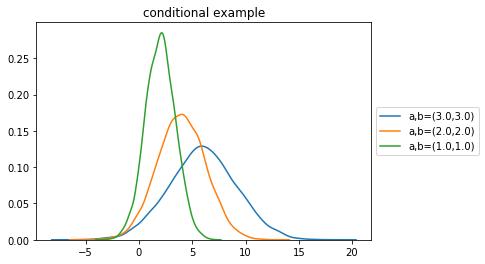

In [0]:
independence = 'conditional'  # 'unconditional', 'dependent'
visualize_data(independence, seaborn=True)

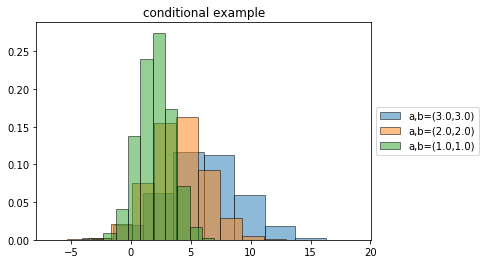

In [0]:
independence = 'conditional'  # 'unconditional', 'dependent'
visualize_data(independence)

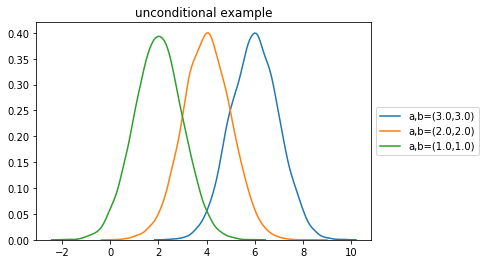

In [0]:
independence = 'unconditional'  # 'unconditional', 'dependent'
visualize_data(independence, seaborn=True)

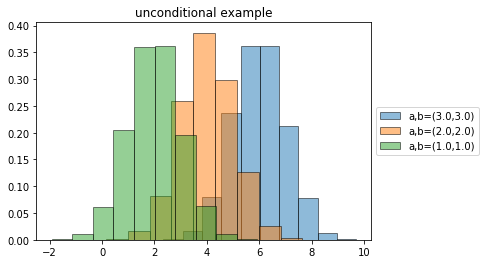

In [0]:
independence = 'unconditional'  # 'unconditional', 'dependent'
visualize_data(independence)

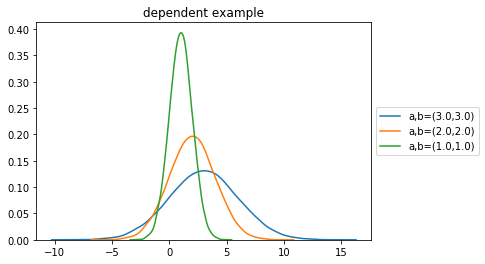

In [0]:
independence = 'dependent'  # 'unconditional', 'dependent'
visualize_data(independence, seaborn=True)

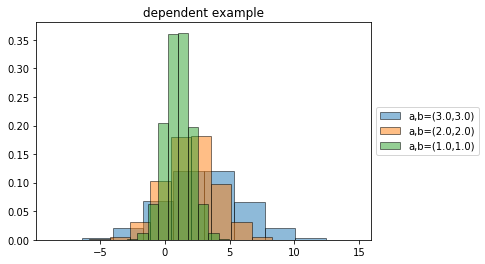

In [0]:
independence = 'dependent'  # 'unconditional', 'dependent'
visualize_data(independence)

### ***Actual training + testing***

In [0]:
def train(model, epoch, fly=False, dataloader=None):
    if fly:
        dataloader = load_multimodal_dataset(latent_mu, latent_sigma, 
                                             alphas, betas, means, sigmas, size=size, 
                                             seed=seed, independence=independence,
                                             batch_size=batch_size, shuffle=shuffle)
    else:
        assert dataloader is not None
    
    num_batches = len(dataloader)

    epoch_loss = []

    for batch_ix, modalities in enumerate(dataloader):
        batch_loss = 0

        # Use their annealing factor setup
        if epoch < annealing_epochs:
            annealing_factor = (float(batch_ix + epoch * num_batches + 1) / 
                                float(annealing_epochs * num_batches))
        else:
            annealing_factor = 1
        modalities = modalities.cuda()

        optimizer.zero_grad()

        # First ELBO term: all modalities
        x_hat, mu, log_var = model(modalities)
        x_hat = x_hat.view(batch_size, -1)
        x = modalities.view(batch_size, -1)

        batch_loss += multimodal_elbo_loss(x_hat, x, mu, log_var, lambda_, 
                                           annealing_factor)
        # Second ELBO term: sum over single modalities
        for ix in range(modalities.shape[1]):
            data_input = [modalities[:, k] if k == ix else None 
                          for k in range(n_modalities)]

            x_hat, mu, log_var = model(data_input)

            batch_loss += multimodal_elbo_loss(x_hat[ix], x[:, ix], 
                                               mu, log_var, 
                                               lambda_, annealing_factor)
        # Third ELBO term: k subsets of all combinations
        onehot_combos = get_combinations(n_modalities, k)
        for combo in onehot_combos:
            data_input = [modalities[:, k] if combo[k] == 1 else None
                          for k in range(n_modalities)]
                        
            x_hat, mu, log_var = model(data_input)

            batch_loss += multimodal_elbo_loss(
                [x_hat[k] for k in range(n_modalities) if combo[k]],
                [x[:, k] for k in range(n_modalities) if combo[k]],
                mu, log_var, lambda_, annealing_factor)
        
        batch_loss.backward()
        optimizer.step()

        epoch_loss.append(batch_loss.item())

    # print('Epoch: {}, Training Loss: {}'.format(epoch, np.mean(epoch_loss)))
    return np.mean(epoch_loss)

In [0]:
def test(model, epoch):
    """Use for validation after training epochs"""
    model.eval()
    dataloader = load_multimodal_dataset(latent_mu, latent_sigma, 
                                         alphas, betas, means, sigmas, size=size, 
                                         seed=seed, independence=independence,
                                         batch_size=batch_size, shuffle=shuffle)
    epoch_loss = 0

    for batch_ix, modalities in enumerate(dataloader):
        modalities = modalities.cuda()

        x_hat, mu, log_var = model(modalities)
        x_hat = x_hat.view(batch_size, -1)
        x = modalities.view(batch_size, -1)

        epoch_loss += multimodal_elbo_loss(x_hat, x, mu, log_var)
    epoch_loss /= len(dataloader)
    return epoch_loss
    # print('Test Loss: {}'.format(epoch_loss))
    


### ***Evaluation***

We seek to determine how well the MVAE does at learning the joint distribution across modalities. To do so, for each modality we can compare its test distribution $p(x_i)$ against our estimates as outputs from the trained MVAE. As in the paper, through training across modalities we have a set of available encoders based on the modality input (e.g. $q(z \mid x_i)$), and then given $z$ we can decode back to the modality of interest. Better models would then be better at generating proper samples of the output modality and converting between input and output modalities.

In [0]:
def eval(model, dataloader_eval):
    """Evaluate method after training"""

    # Store all reconstructed distributions
    dict_recon_x = {}

    # Save groundtruths
    groundtruth_x = [[] for i in range(n_modalities)]
    for batch_ix, modalities in enumerate(dataloader_eval):
        for ix in range(modalities.shape[1]):
            groundtruth_x[ix].extend(modalities[:, ix].detach().cpu().numpy())

    def store_data(x_hat, key):
        if key not in dict_recon_x:
            dict_recon_x[key] = {}
            for m in range(len(x_hat)):
                dict_recon_x[key][m] = x_hat[m]
        else:
            for m in range(len(x_hat)):
                # print(dict_recon_x[key][m].shape)
                # print(x_hat[m].shape)
                dict_recon_x[key][m] = torch.cat([dict_recon_x[key][m], x_hat[m]])
    # recon_x = [[] for _ in range(1 + n_modalities)]  # + k

    onehot_combos = get_combinations(n_modalities, k)

    with torch.no_grad():
        i = 0
        for batch_ix, modalities in enumerate(dataloader_eval):
            modalities = modalities.cuda()

            # Reconstruction from all modalities
            x_hat, mu, log_var = model(modalities)

            key = 'all'
            store_data(x_hat.detach().cpu(), key)

            # Reconstruction from singular modalities
            for ix in range(modalities.shape[1]):
                i += 1
                data_input = [modalities[:, k] if k == ix else None 
                              for k in range(n_modalities)]

                x_hat, mu, log_var = model(data_input)

                key = 'single-{}'.format(ix)
                store_data(x_hat.detach().cpu(), key)
                
                # recon_x[i].extend(x_hat.detach().cpu())

            # Reconstruction from random missing modalities
            for combo in onehot_combos:
                data_input = [modalities[:, k] if combo[k] == 1 else None
                              for k in range(n_modalities)]
                            
                x_hat, mu, log_var = model(data_input)

                key = 'combo-{}'.format([k for k in range(n_modalities) if combo[k] == 1])
                store_data(x_hat.detach().cpu(), key)

            i = 0  # reset
    return dict_recon_x, groundtruth_x

In [0]:
def visualize_reconstruction(dict_recon_x, groundtruth_x, ylim=None):
    for k in dict_recon_x:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 3))
        for ix in range(3):
            axes[ix].hist(dict_recon_x[k][ix], alpha=0.5, density=True, 
                    label='Generated', 
                    edgecolor='black')
            axes[ix].hist(groundtruth_x[ix], alpha=0.5, density=True,
                    label='Groundtruth', 
                    edgecolor='black')
            axes[ix].set_title('Input: {}, Output: {}'.format(k, ix))
            axes[ix].legend()
            if ylim:
                axes[ix].set_ylim([0., ylim])
        fig.tight_layout()
        plt.show()

With our model and dataset methods implemented, we move on to the pedagogical examples.

## ***Example Case 1: Conditionally Independent Data***

As a reminder here we assume an underlying $Z \sim \mathcal{N}(\mu, \sigma^2)$, and then each of our modalities is given by

$$
X_i \sim a_iZ + b_i + \mathcal{N}(\mu_i, \sigma_i^2)
$$

Specifically, we illustrate the example with $Z \sim \mathcal{N}(0, 1)$, $a_i$, $b_i$, $\mu_i$ are all the $i$-th element in the ordered set of integers $[1, 2, \ldots, N]$ where $N = 3$ modalities, and $\sigma_i^2 = 1$ for all $i$.

### ***Case 1: Training***

In [0]:
# Stick to their hyperparameters if it makes sense
epochs = 20
batch_size = 100
latent_dim = 1
annealing_epochs = 20
lr = 1e-3
shuffle = True
seed = 42
cuda = True  # just going to assume this if we're only running on colab
lambda_ = 1.

# Experimental design parameters - change these for different examples
latent_mu = 0
latent_sigma = 1
independence = 'conditional'  # 'unconditional', 'dependent'

## Data generation
n_modalities = 3  # 10
k = 6
alphas = np.array(range(1, n_modalities + 1), dtype=float)
betas = means = np.array(range(1, n_modalities + 1), dtype=float)
means = np.array(range(1, n_modalities + 1), dtype=float)
sigmas = np.ones(n_modalities)
size = 10000


model_1 = MVAE(n_modalities=n_modalities, latent_dim=latent_dim)
optimizer = optim.Adam(model_1.parameters(), lr=lr)

model_1.cuda()

dataloader = load_multimodal_dataset(latent_mu, latent_sigma, 
                                     alphas, betas, means, sigmas, size=size, 
                                     seed=seed, independence=independence,
                                     batch_size=batch_size, shuffle=shuffle)
num_batches = len(dataloader)

losses_1 = []

for epoch in range(epochs):
    train_loss = train(model_1, epoch, fly=False, dataloader=dataloader)
    test_loss = test(model_1, epoch)
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(
        epoch, train_loss, test_loss))
    losses_1.append(test_loss)
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch: 0, Training Loss: 38705.67263671875, Validation Loss: 6185.84423828125
Epoch: 1, Training Loss: 33142.871484375, Validation Loss: 5085.18798828125
Epoch: 2, Training Loss: 24248.1666015625, Validation Loss: 3427.52294921875
Epoch: 3, Training Loss: 16454.86259765625, Validation Loss: 3511.102783203125
Epoch: 4, Training Loss: 14186.6343359375, Validation Loss: 3711.86669921875
Epoch: 5, Training Loss: 12959.09802734375, Validation Loss: 3703.654296875
Epoch: 6, Training Loss: 12152.883388671875, Validation Loss: 3690.32275390625
Epoch: 7, Training Loss: 11650.622861328126, Validation Loss: 3679.7177734375
Epoch: 8, Training Loss: 11289.93013671875, Validation Loss: 3677.7958984375
Epoch: 9, Training Loss: 10980.292875976562, Validation Loss: 3680.091552734375
Epoch: 10, Training Loss: 10664.743486328125, Validation Loss: 3682.706787109375
Epoch: 11, Training Loss: 10395.510356445313, Validation Loss: 3682.482666015625
Epoch: 12, Training Loss: 10154.332001953126, Validation Loss

### ***Case 1: Evaluation***

Here we do qualitative evaluation with visual inspection of the densities. Given that we are trying to learn the joint distribution of the modalities, we consider how effective the MVAE is at reconstructing all three data modalities, given the input modalities. To test the author's claim of being able to learn joint representations in situations where some modalities are abundant but others may be unavailable, we visualize the reconstructions with ablations on how many modalities we are given as input. Additionally, with a relatively small number of modalities ($N = 3$), it is computationally tractable to enumerate through all the combinations. However, as the number of combinations groes exponentially, with more time, we can also perform ablation studies on the number of included combinations we randomly select during training.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


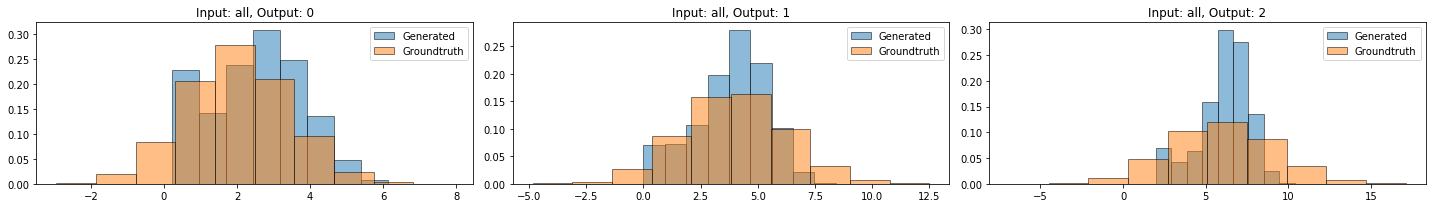

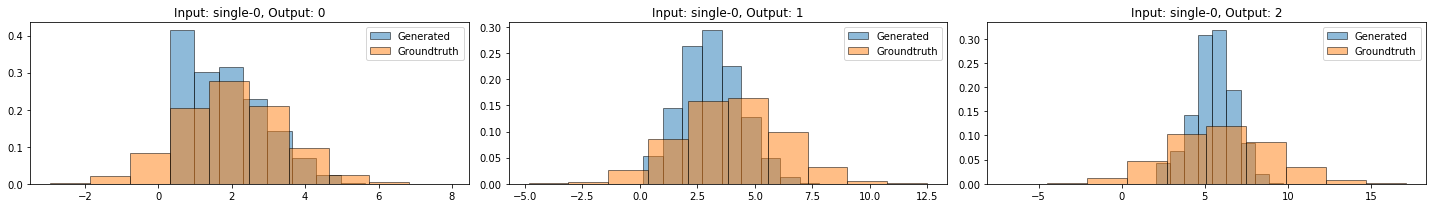

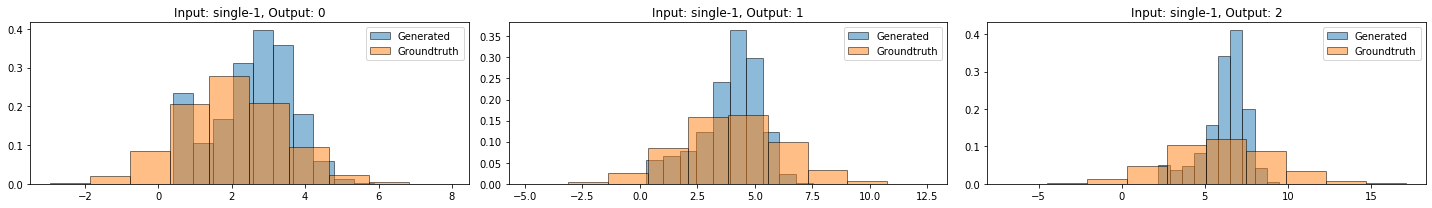

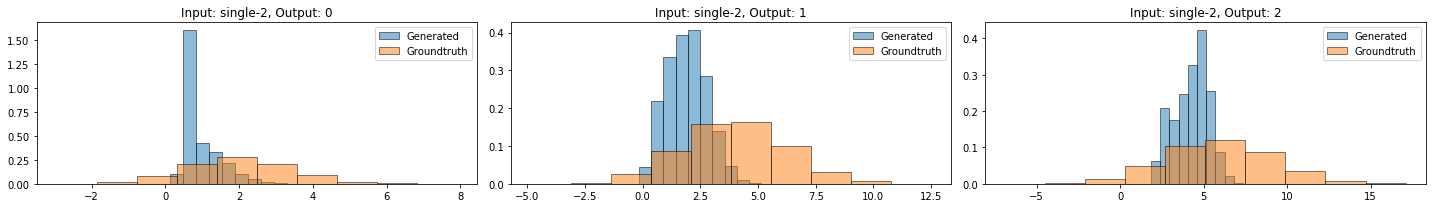

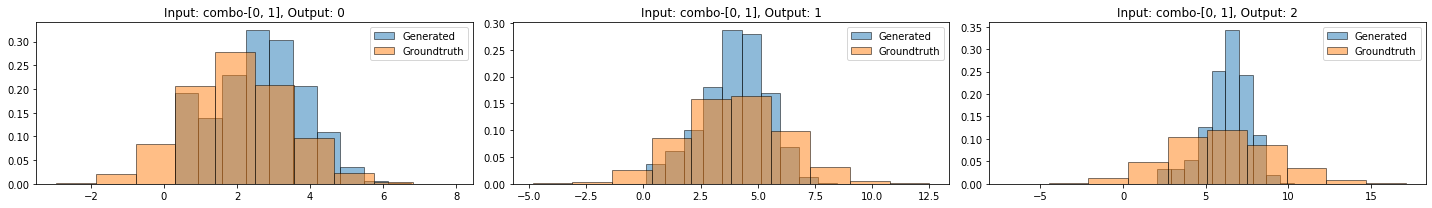

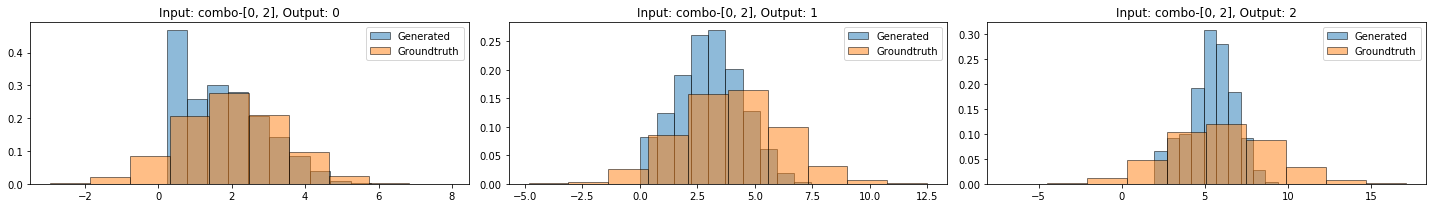

In [0]:
# Experimental design parameters - change these for different examples
latent_mu = 0
latent_sigma = 1
independence = 'conditional'  # 'unconditional', 'dependent'

## Data generation
n_modalities = 3  # 10
k = 6
alphas = np.array(range(1, n_modalities + 1), dtype=float)
betas = means = np.array(range(1, n_modalities + 1), dtype=float)
means = np.array(range(1, n_modalities + 1), dtype=float)
sigmas = np.ones(n_modalities)
size = 10000

seed = 12
dataloader = load_multimodal_dataset(latent_mu, latent_sigma, 
                                     alphas, betas, means, sigmas, size=size, 
                                     seed=seed, independence=independence,
                                     batch_size=batch_size, shuffle=shuffle)
dict_recon_x_1, groundtruth_x_1 = eval(model_1, dataloader)

visualize_reconstruction(dict_recon_x_1, groundtruth_x_1)

In [0]:
# dataloader_eval

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


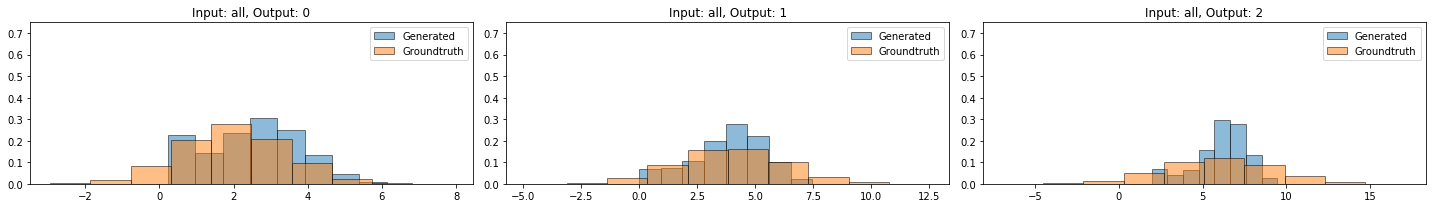

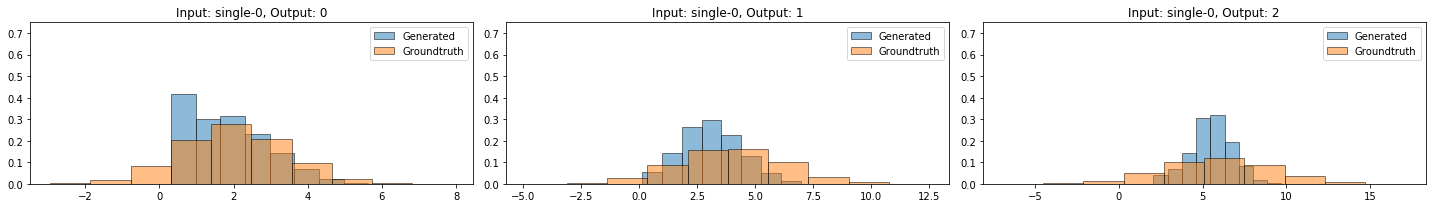

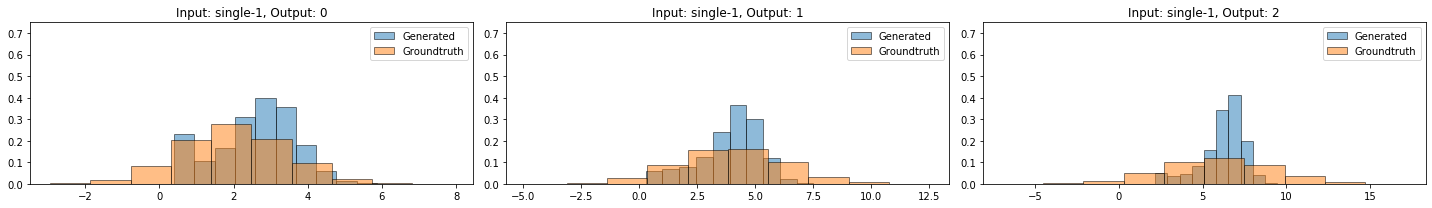

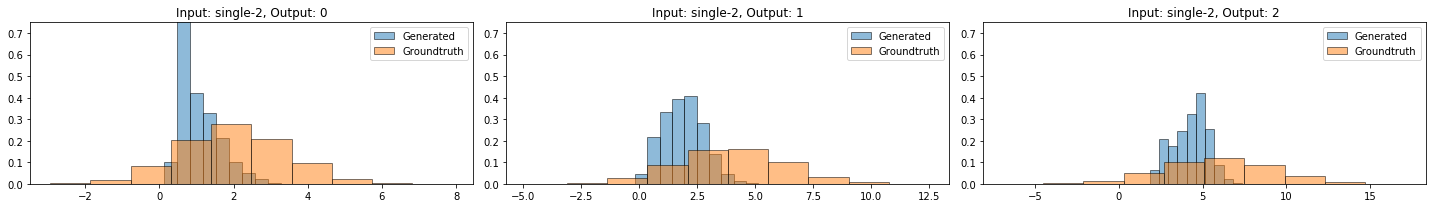

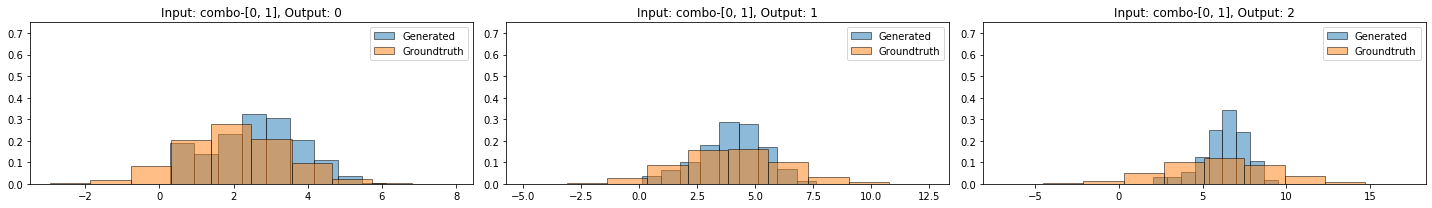

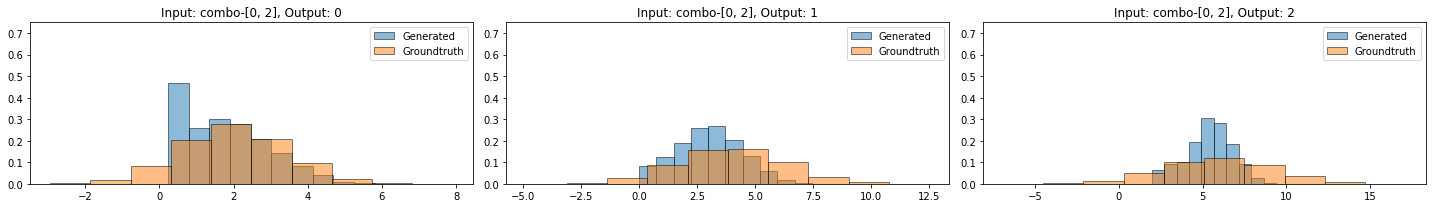

In [0]:
# Experimental design parameters - change these for different examples
latent_mu = 0
latent_sigma = 1
independence = 'conditional'  # 'unconditional', 'dependent'

## Data generation
n_modalities = 3  # 10
k = 6
alphas = np.array(range(1, n_modalities + 1), dtype=float)
betas = means = np.array(range(1, n_modalities + 1), dtype=float)
means = np.array(range(1, n_modalities + 1), dtype=float)
sigmas = np.ones(n_modalities)
size = 10000

seed = 12
dataloader = load_multimodal_dataset(latent_mu, latent_sigma, 
                                     alphas, betas, means, sigmas, size=size, 
                                     seed=seed, independence=independence,
                                     batch_size=batch_size, shuffle=shuffle)
dict_recon_x_1, groundtruth_x_1 = eval(model_1, dataloader)

visualize_reconstruction(dict_recon_x_1, groundtruth_x_1, ylim=0.75)

To demonstrate that the observed data is consistent across all our ablations, for case 1, we include visualizations with consistent and adjusted y axes. Here and in the subsequent examples, the input and output modalities are denoted in the titles of the subplots. We note that the MVAE approximates the modalities with varying degrees of success, and in general performs better the more input modalities are available. We can see this explicitly comparing the top row describing having all modalities available, versus reconstructing all three modalities with only a single modality. Nevertheless, when the data sufficiently fits our modeling assumptions, the ability to reasonably approximate modalities when we are missing them at test time in this situation speaks to the MVAE's ability to learn a joint representation during training.

With regard to only using a subset of modalities, it is also interesting to note that certain modalities as inputs do better than others. For example, with only modality 0, we are able to achieve reasonable approximations, and it appears that combinations that include this modality similarly do well. On the other hand, introducing a modality that by itself does not do well actually seems to hurt the ability to model all distributions. This might suggest that certain modalities that are relatively unrepresentative of the underlying latent distribution may hurt our overall generative model. Wu et al. did not include the generalized Product-of-Experts (gPoE), which would include an additional weighting factor for each modality that can be learned to determine how much influence each modality should have, and so with this observation we have motivation for follow-on work to explore the use of the gPoE and other methods that take reliability or representativeness of each modality into account.

---

## ***Example Case 2: Dependent Data***

Now as we look at situations where the modalities are dependent on each other. In the original MVAE paper, the authors make the assumption that the modalities are conditionally independent from each other, but all share a dependency with some underlying distribution. Here we seek to explore the robustness of this inductive bias on a dataset specifically designed to be dependent across modalities.  

Given an underlying $Z \sim \mathcal{N}(\mu, \sigma^2)$, each of our modalities is then just a linear transform of the latent variable, given by

$$
X_i \sim a_iZ + b_i
$$

Specifically, we illustrate the example with $Z \sim \mathcal{N}(0, 1)$, $a_i$ and $b_i$ are the $i$-th element in the ordered set of integers $[1, 2, \ldots, N]$ where $N = 3$ modalities

### ***Case 2: Training***

In [0]:
# Stick to their hyperparameters if it makes sense
epochs = 20
batch_size = 100
latent_dim = 1
annealing_epochs = 20
lr = 1e-3
shuffle = True
seed = 42
cuda = True  # just going to assume this if we're only running on colab
lambda_ = 1.

# Experimental design parameters - change these for different examples
latent_mu = 0
latent_sigma = 1
independence = 'dependent'  # 'unconditional', 'dependent'

## Data generation
n_modalities = 3  # 10
k = 6
alphas = np.array(range(1, n_modalities + 1), dtype=float)
betas = means = np.array(range(1, n_modalities + 1), dtype=float)
means = np.array(range(1, n_modalities + 1), dtype=float)
sigmas = np.ones(n_modalities)
size = 10000


model_2 = MVAE(n_modalities=n_modalities, latent_dim=latent_dim)
optimizer = optim.Adam(model_2.parameters(), lr=lr)

model_2.cuda()

dataloader = load_multimodal_dataset(latent_mu, latent_sigma, 
                                     alphas, betas, means, sigmas, size=size, 
                                     seed=seed, independence=independence,
                                     batch_size=batch_size, shuffle=shuffle)
num_batches = len(dataloader)

losses_2 = []

for epoch in range(epochs):
    train_loss = train(model_2, epoch, fly=False, dataloader=dataloader)
    test_loss = test(model_2, epoch)
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(
        epoch, train_loss, test_loss))
    losses_2.append(test_loss)
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch: 0, Training Loss: 14791.953359375, Validation Loss: 2172.7236328125
Epoch: 1, Training Loss: 10242.651103515625, Validation Loss: 1912.7564697265625
Epoch: 2, Training Loss: 7269.980688476562, Validation Loss: 2209.116455078125
Epoch: 3, Training Loss: 6353.937075195313, Validation Loss: 2304.091796875
Epoch: 4, Training Loss: 5542.447492675781, Validation Loss: 2411.68896484375
Epoch: 5, Training Loss: 5016.213449707031, Validation Loss: 2512.130859375
Epoch: 6, Training Loss: 4699.129738769531, Validation Loss: 2601.95703125
Epoch: 7, Training Loss: 4535.975358886719, Validation Loss: 2649.069580078125
Epoch: 8, Training Loss: 4470.792177734375, Validation Loss: 2663.3271484375
Epoch: 9, Training Loss: 4427.552072753906, Validation Loss: 2672.03271484375
Epoch: 10, Training Loss: 4391.910559082031, Validation Loss: 2676.853759765625
Epoch: 11, Training Loss: 4359.669541015625, Validation Loss: 2679.192138671875
Epoch: 12, Training Loss: 4329.120930175781, Validation Loss: 2679

### ***Case 2: Evaluation***

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


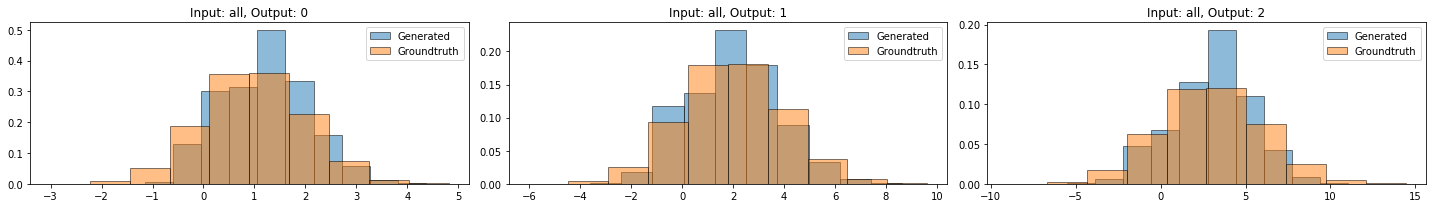

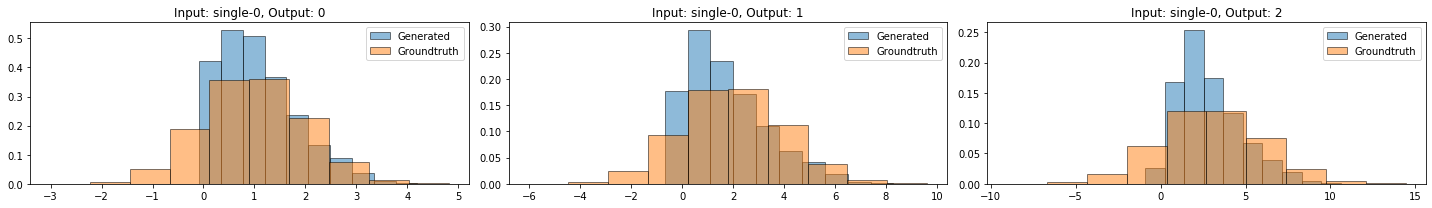

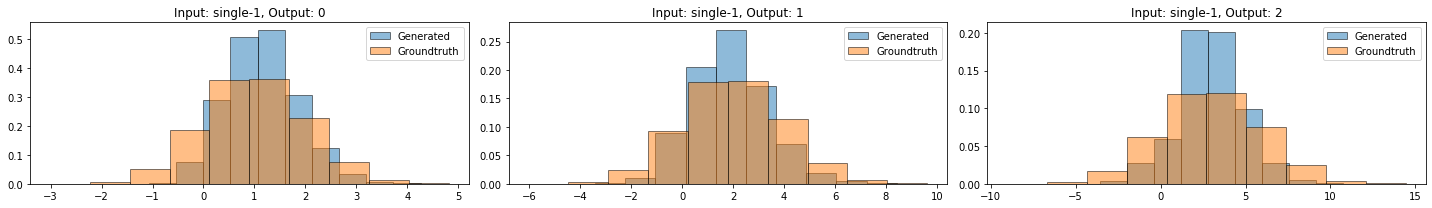

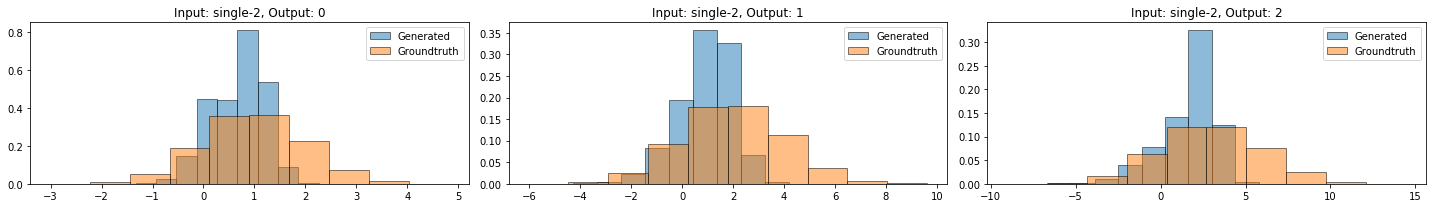

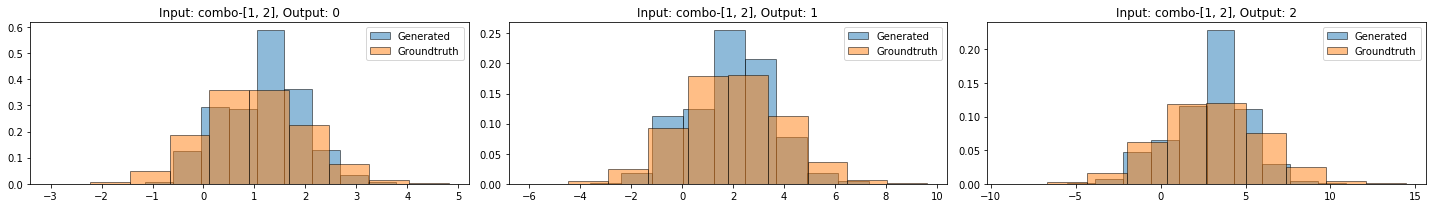

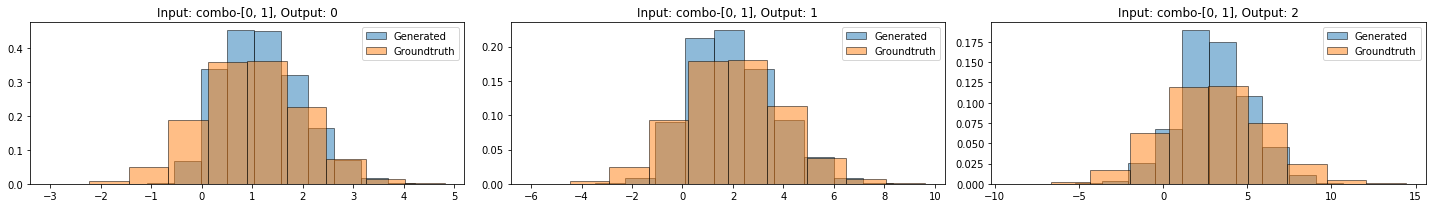

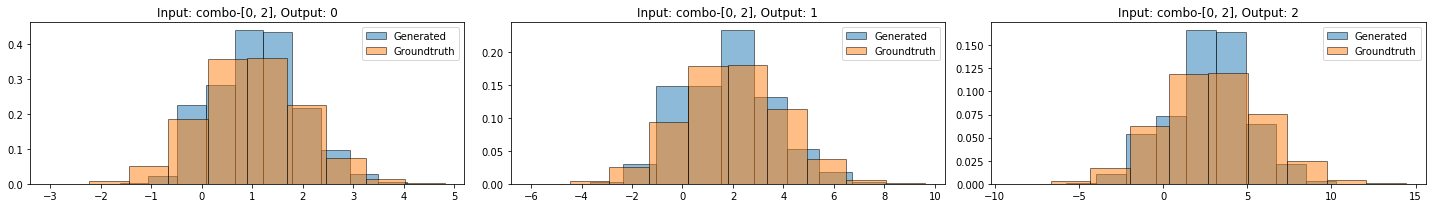

In [0]:
# Experimental design parameters - change these for different examples
latent_mu = 0
latent_sigma = 1
independence = 'dependent'  # 'unconditional', 'dependent'

## Data generation
n_modalities = 3  # 10
k = 6
alphas = np.array(range(1, n_modalities + 1), dtype=float)
betas = means = np.array(range(1, n_modalities + 1), dtype=float)
means = np.array(range(1, n_modalities + 1), dtype=float)
sigmas = np.ones(n_modalities)
size = 10000

seed = 12
dataloader = load_multimodal_dataset(latent_mu, latent_sigma, 
                                     alphas, betas, means, sigmas, size=size, 
                                     seed=seed, independence=independence,
                                     batch_size=batch_size, shuffle=shuffle)
dict_recon_x_2, groundtruth_x_2 = eval(model_2, dataloader)

visualize_reconstruction(dict_recon_x_2, groundtruth_x_2)

We note that with a stronger dependence assumption, the MVAE seems to perform beeter at matching the groundtruth modality distributions. This is expected because we might imagine that modalities that are actually just dependent on each other would be an easier case to learn, given that each modality and the subsequent combinations would be more representative of another, and at least in our pedagogical example each modality is a straightforward linear transformation of the latent variable.

---

## ***Example Case 3: Independent Data***

Now as we look at situations where the modalities are independent from each other. This scenario is perhaps a bit extreme with regard to searching for failure modes because we would imagine that different modalities should share some underlying dependency-they are afterall different forms of information describing the same thing, which makes the original assumption of conditional independence in the MVAE paper reasonable. Nevertheless, in reality although two forms of data may be describing the same inherent thing, their observed distributions may appear very distinct. For example, although a picture and its corresponding caption both serve to describe some entity, the RGB pixel data of the image and the onehot-encoded vectors representing the words in a caption are rather different modalities, such that the underlying content that might be learned in an embedding is only discovered with multiple layers compositions of non-linear functions with many parameters.

Specifically, we assume our modalities come from independent Normals, e.g. 

$$
X_i \sim b_i + \mathcal{N}(\mu_i, \sigma_i^2)
$$

where $b_i$, $\mu_i$ are both the $i$-th element in the ordered set of integers $[1, 2, \ldots, N]$ where $N = 3$ modalities, and $\sigma_i^2 = 1$ for all $i$.

### ***Case 3: Training***

In [0]:
# Stick to their hyperparameters if it makes sense
epochs = 20
batch_size = 100
latent_dim = 1
annealing_epochs = 20
lr = 1e-3
shuffle = True
seed = 42
cuda = True  # just going to assume this if we're only running on colab
lambda_ = 1.

# Experimental design parameters - change these for different examples
latent_mu = 0
latent_sigma = 1
independence = 'unconditional'  # 'unconditional', 'dependent'

## Data generation
n_modalities = 3  # 10
k = 6
alphas = np.array(range(1, n_modalities + 1), dtype=float)
betas = means = np.array(range(1, n_modalities + 1), dtype=float)
means = np.array(range(1, n_modalities + 1), dtype=float)
sigmas = np.ones(n_modalities)
size = 10000


model_3 = MVAE(n_modalities=n_modalities, latent_dim=latent_dim)
optimizer = optim.Adam(model_3.parameters(), lr=lr)

model_3.cuda()

dataloader = load_multimodal_dataset(latent_mu, latent_sigma, 
                                     alphas, betas, means, sigmas, size=size, 
                                     seed=seed, independence=independence,
                                     batch_size=batch_size, shuffle=shuffle)
num_batches = len(dataloader)

losses_3 = []

for epoch in range(epochs):
    train_loss = train(model_3, epoch, fly=False, dataloader=dataloader)
    test_loss = test(model_3, epoch)
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(
        epoch, train_loss, test_loss))
    losses_3.append(test_loss)
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch: 0, Training Loss: 31464.65337890625, Validation Loss: 3844.061279296875
Epoch: 1, Training Loss: 18640.861357421876, Validation Loss: 1491.794677734375
Epoch: 2, Training Loss: 10658.280737304687, Validation Loss: 1591.036865234375
Epoch: 3, Training Loss: 8625.5951171875, Validation Loss: 1618.871337890625
Epoch: 4, Training Loss: 6716.8443359375, Validation Loss: 1696.641845703125
Epoch: 5, Training Loss: 5650.402172851563, Validation Loss: 1780.2847900390625
Epoch: 6, Training Loss: 5287.2263671875, Validation Loss: 1797.29736328125
Epoch: 7, Training Loss: 5038.758833007812, Validation Loss: 1795.75830078125
Epoch: 8, Training Loss: 4803.668427734375, Validation Loss: 1793.73388671875
Epoch: 9, Training Loss: 4599.463618164063, Validation Loss: 1796.3099365234375
Epoch: 10, Training Loss: 4425.385307617187, Validation Loss: 1794.0001220703125
Epoch: 11, Training Loss: 4263.724711914063, Validation Loss: 1789.0352783203125
Epoch: 12, Training Loss: 4097.049521484375, Validati

### ***Case 3: Evaluation***

Here we do qualitative evaluation with visual inspection of the densities.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


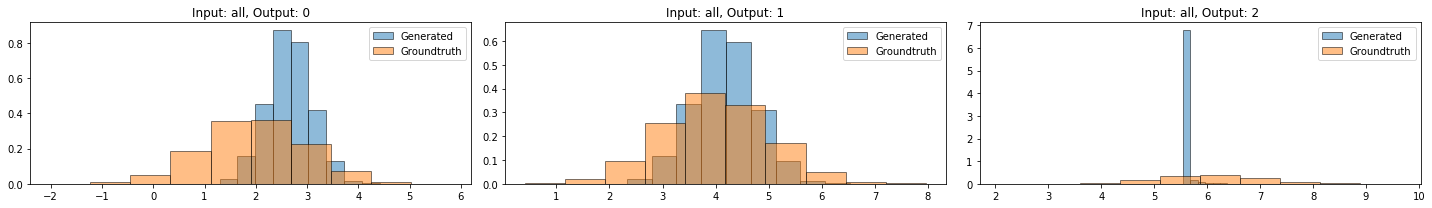

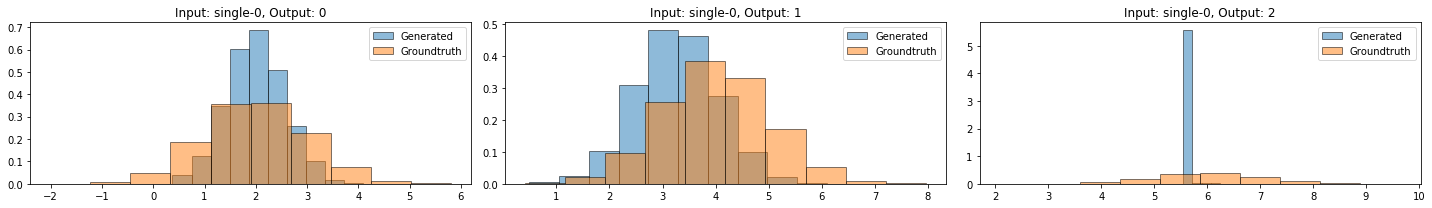

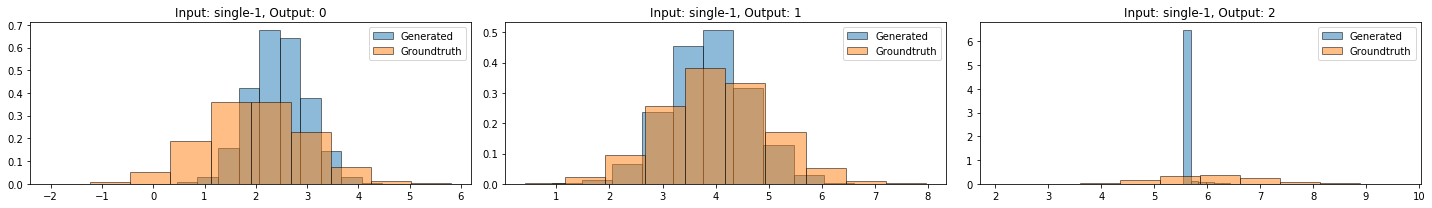

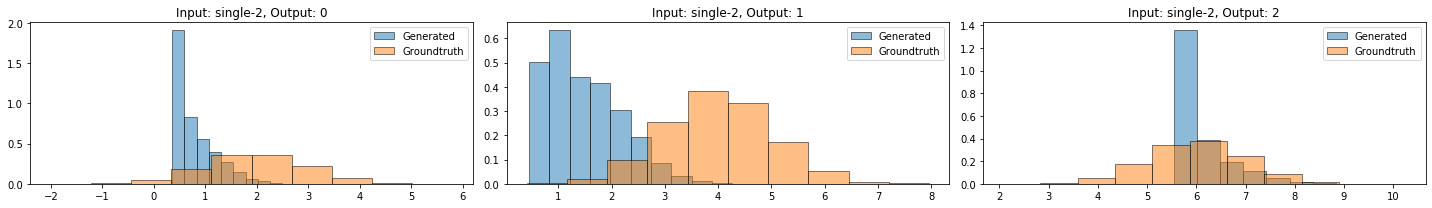

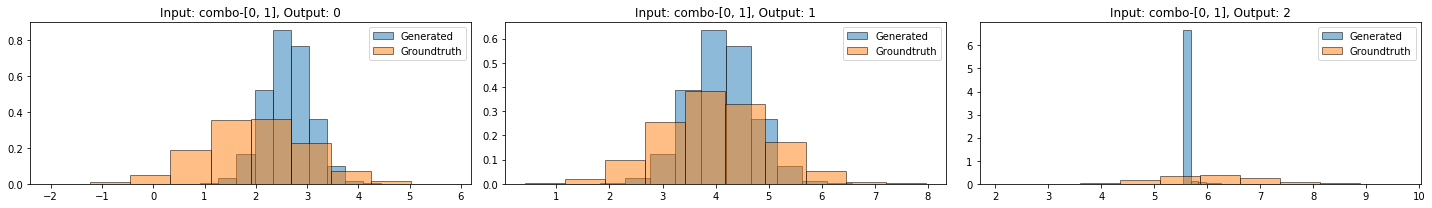

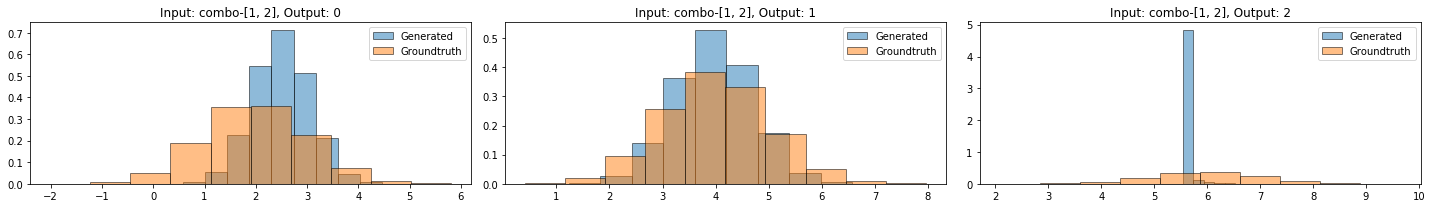

In [0]:
# Experimental design parameters - change these for different examples
latent_mu = 0
latent_sigma = 1
independence = 'unconditional'  # 'unconditional', 'dependent'

## Data generation
n_modalities = 3  # 10
k = 6
alphas = np.array(range(1, n_modalities + 1), dtype=float)
betas = means = np.array(range(1, n_modalities + 1), dtype=float)
means = np.array(range(1, n_modalities + 1), dtype=float)
sigmas = np.ones(n_modalities)
size = 10000

seed = 12
dataloader = load_multimodal_dataset(latent_mu, latent_sigma, 
                                     alphas, betas, means, sigmas, size=size, 
                                     seed=seed, independence=independence,
                                     batch_size=batch_size, shuffle=shuffle)
dict_recon_x_3, groundtruth_x_3 = eval(model_3, dataloader)

visualize_reconstruction(dict_recon_x_3, groundtruth_x_3)

In our final example, we observe that when the modalities are independent of each other, our estimations of the individual modality distributions are mostly consistent poor for certain modalities regardless of the number of available modalities or which modalities these are. This seems like expected behavior as with completely independent modalities, we are reasonably stepping out of the presented modeling capability of learning an underlying joint distribution explainable by a shared latent distributions.

---

## ***Discussion and Future Work***

Through our pedagogical example of numerical distributions, we were able to illustrate three possible modality scenarios and the MVAE's respective performance. Perhaps unsurprisingly, the model did best when the data was explicitly generated under a more helpful stronger assumption. Performance decreased when data was generated to fit the MVAE's conditional dependence assumption across modalities allowing the product-of-experts formuation and finally did worst in the setting where the assumption was false.. 

We now further consider instances in the paper that could be expanded upon or improved on, suggesting follow-on work.

#### ***1. Scalable multimodal learning***

While the authors claim that their method is able to efficiently and effectively learn joint distributions across multiple modalities, in their provided experiments they only evaluate with one real setup using the CelebA dataset (MVAE19), where images are still one modality but 19 attributes describing the various images are each treated as a separate modality. While success on CelebA may suggest success on MNIST, further experiments working with more than 2 modalities would have been nice to illustrate the robustness of the model, especially because the contribution of being able to tractably learn the joint distribution of multiple modalities without having to train on every combination was so emphasized in the introduction and with respect to previous multimodal generative models.

#### ***2. Sub-sampling heuristic***

With regard to dealing with more than two modalities and model robustness in the form of missing modalities, the authors propose a sub-sampling method that while reasonable, is also a heuristic. Motivated by the ELBO, they calculate the model's ELBO on a subset of randomly selected combinations, and optimize this jointly with the ELBO over all available modalities and each single modality. This method is subject to the number of combinations used during training (denoted by $k$ in the paper). They do include a result varying $k$ from $0$ to $50$ and show how model performance increases with higher $k$ (which is an intuitive result as well so we did not include this in our pedagogical example), but it leaves an open question if the simple method can be improved. Does it make sense to just sample combinations uniform randomly? Perhaps some combinations of modalities are more prominent than others, and so a weighted distribution might make the model more practical with respect to down-stream weakly supervised learning.


#### ***3. What counts as a modality?***

In relation to the above, the modalities were limited to text and images. While practically, these two modalities may be sufficient as computer vision and NLP are both rather mature and much real world understanding comes through these two modalities, it would have been nice to consider the semantics of what counts as a modality, and perhaps motivate more experiments with more modalities. The case study of computer vision, where given an underlying image, each modality is a transformation used in common image processing tasks (e.g. showing only the edges for edge detection, or blocking half the image for partial reconstruction) was an interesting example of expanding the modalities available. That being said, image and text remain natural and obvious choices, and although this was less the authors and more a field paradigm, it is still cool how treating the labels as a text modality can enable weakly-supervised learning when trying to do multi-modal learning with modal imbalance.

#### ***4. Learnable modality influence***

Finally as noted earlier, one prominent component that was missing from the paper was the generalized product of experts (gPoE), which aims to identify which modalities are more reliable or important at learning the joint distribution. Accordingly, instead of 

$$
P(y \mid x) = \frac{1}{N}\prod_{i}p_i(y \mid x), \text{ where }p_i(y \mid x) = \mathcal{N}(m_i(x), \Sigma_i(x))
$$

in the supervised setting for $N$ experts, with the product given as
$$
P(y \mid x) \sim \mathcal{N}(m(x), \Sigma(x))
$$
where
$$
m(x) = \Big(\sum_{i}^N m_i(x) T_i(x)\Big) \cdot \Big(\sum_i T_i(x)\Big)^{-1}
\text{ and }
\Sigma(x) = \Big(\sum_{i}^N T_i(x)\Big)^{-1}
$$
and $T_i(x) = \Sigma_i^{-1}(x)$, as in Cao et al. we would have

$$
P(y \mid x) = \frac{1}{N}\prod_{i}p_i^{a_i}(y \mid x)
$$

where $a_i(x)$ can be learned as a weighting for how reliable the $i$-th expert is at datapoint $x$. With the Gaussian assumptions, we could then implement this with

$$
m(x) = \Big(\sum_{i}^N m_i(x) a_i(x) T_i(x)\Big) \cdot \Big(\sum_i a_i(x) T_i(x)\Big)^{-1}
$$
$$
\Sigma(x) = \Big(\sum_{i}^N a_i(x) T_i(x)\Big)^{-1}
$$



As observed in our pedagogical example, certain modalities are more representative of the larger set of modalities than others, and so could be given more weight in the PoE framework for estimation. This could also motivate ideas related to active learning that choose which sub-sampled combinations of modalities should be selected for training.